In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install pyspark
!pip install gcsfs

In [3]:
# Kill existing Spark session (if any)
try:
    spark.stop()
except NameError:
    pass  # Ignore if 'spark' is not defined yet


# Create a new Spark session with updated configuration
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GCS with PySpark in Colab") \
    .config("spark.jars.packages", "com.google.cloud.bigdataoss:gcs-connector:hadoop3-2.2.10") \
    .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .getOrCreate()

In [4]:
import os

project_id = "project-clickstream-team-81" # Replace with your project ID
bucket_name = "raw_partitioned-2"
dataset_name = "partitioned_output1"
date = "2023-05-01"  # Variable for date
hour = "00"  # Variable for hour

# Define the source GCS path and destination local path
source_path = f"gs://{project_id}/{bucket_name}/{dataset_name}/day={date}/hour={hour}/*.parquet"
local_path = f"/tmp/{date}_{hour}/"  # Define a local directory

# Create the local directory if it doesn't exist
os.makedirs(local_path, exist_ok=True)

# Download the Parquet files from GCS to local
!gsutil -m cp -r {source_path} {local_path}

# Read the Parquet files from the local directory into a Spark DataFrame
df = spark.read.parquet(local_path)


# Display the schema and first few rows of the DataFrame
df.printSchema()
df.show()

Copying gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-05-01/hour=00/part-00002-6a6622c1-98c6-4ffa-87c6-24cba26ef892.c000.snappy.parquet...
Copying gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-05-01/hour=00/part-00003-6a6622c1-98c6-4ffa-87c6-24cba26ef892.c000.snappy.parquet...
Copying gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-05-01/hour=00/part-00001-6a6622c1-98c6-4ffa-87c6-24cba26ef892.c000.snappy.parquet...
Copying gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-05-01/hour=00/part-00000-6a6622c1-98c6-4ffa-87c6-24cba26ef892.c000.snappy.parquet...
Copying gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-05-01/hour=00/part-00004-6a6622c1-98c6-4ffa-87c6-24cba26ef892.c000.snappy.parquet...
Copying gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-05-01/hour=00/part-00005-6a6622c1-98c6-4ffa-87c

## Creating the DAG

In [5]:
import pandas as pd
import networkx as nx
from pyspark.sql.functions import *

In [6]:
# Convert 'time' column to datetime
df = df.withColumn('time', to_timestamp(df['time']))

In [7]:
# Sort the DataFrame by userId and time
df_sorted = df.orderBy(['token', 'time'])

In [17]:
from pyspark.sql import Window
from pyspark.sql.functions import *

# Using a window function, within each token group, assign row numbers based on time ordering
window_spec = Window.partitionBy('token').orderBy('time')
df_row_number = df_sorted.withColumn('row_number', row_number().over(window_spec))

# Create 2 duplicates of the DataFrame for self-join, with separate time columns for source and target
df_1 = df_row_number.withColumnRenamed("url", "source") \
                        .withColumnRenamed("row_number", "row_1") \
                        .withColumnRenamed("time", "source_time")
df_2 = df_row_number.withColumnRenamed("url", "target") \
                        .withColumnRenamed("row_number", "row_2") \
                        .withColumnRenamed("time", "target_time")

# Perform a self-join where, for each token, row_2 is the next row after row_1
# This ensures that the clicks are consecutive
edges_df = df_1.join(df_2,
                     (df_1["token"] == df_2["token"]) & (df_2["row_2"] == df_1["row_1"] + 1),
                     how="inner")

# Calculate the time difference between consecutive clicks
edges_df = edges_df.withColumn("time_diff", col("target_time").cast("long") - col("source_time").cast("long"))

# Select only the relevant columns for edges_df
edges_df = edges_df.select("source", "target", "source_time", "target_time", "time_diff")

In [18]:
# Filter out rows with None values in 'source' or 'target'
edges_df = edges_df.filter(edges_df['source'].isNotNull() & edges_df['target'].isNotNull())

In [19]:
import networkx as nx

# Initialize the directed graph
G = nx.DiGraph()

# Convert edges_df to a list of tuples
edges = [(row["source"], row["target"], {"time_diff": row["time_diff"]}) for row in edges_df.collect()]

# Add edges to the graph
G.add_edges_from(edges)

In [11]:
# Collect source nodes and target nodes
source_nodes = edges_df.select("source", "source_time").distinct()
target_nodes = edges_df.select("target", "target_time").distinct()

# Convert source and target nodes to lists of tuples
source_nodes = [(row["source"], {"time": row["source_time"]}) for row in source_nodes.collect()]
target_nodes = [(row["target"], {"time": row["target_time"]}) for row in target_nodes.collect()]

# Add nodes to the graph
G.add_nodes_from(source_nodes)
G.add_nodes_from(target_nodes)

In [20]:
# Display some basic information about the DAG
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 43
Number of edges: 86


In [28]:
edges_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- target: string (nullable = true)
 |-- source_time: timestamp (nullable = true)
 |-- target_time: timestamp (nullable = true)
 |-- time_diff: long (nullable = true)



In [22]:
edges_df.show(5)

+--------------------+--------------------+-------------------+-------------------+---------+
|              source|              target|        source_time|        target_time|time_diff|
+--------------------+--------------------+-------------------+-------------------+---------+
|https://4fstore.l...|https://4fstore.l...|2023-05-01 00:01:15|2023-05-01 00:01:16|        1|
|https://4fstore.l...|https://4fstore.l...|2023-05-01 00:01:16|2023-05-01 00:01:16|        0|
| https://4fstore.lv/| https://4fstore.lv/|2023-05-01 00:01:19|2023-05-01 00:01:24|        5|
| https://4fstore.lv/| https://4fstore.lv/|2023-05-01 00:01:24|2023-05-01 00:01:24|        0|
| https://4fstore.lv/|https://4fstore.l...|2023-05-01 00:01:24|2023-05-01 00:01:43|       19|
+--------------------+--------------------+-------------------+-------------------+---------+
only showing top 5 rows



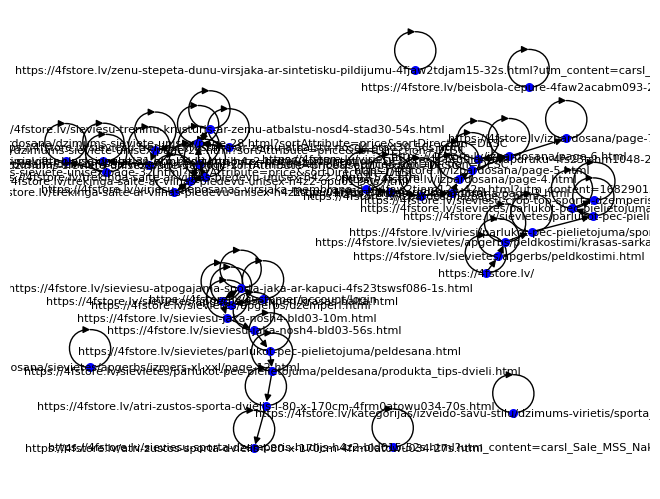

In [23]:
# (Optional) Visualize the DAG (requires matplotlib)
import matplotlib.pyplot as plt

nx.draw(G, with_labels=True, node_size=30, node_color='blue', font_size=8)
plt.show()

## Create table to match the schema of page_analytics.page_navigation_dag

CREATE TABLE page_analytics.page_navigation_dag (<br>
  source_page_id INT64,            -- Page ID of the starting page <br>
  destination_page_id INT64,       -- Page ID of the destination page <br>
  transition_count INT64,          -- Total count of transitions from source to destination <br>
  avg_time_between_pages FLOAT64,  -- Average time taken to navigate from source to destination <br>
  last_visit_timestamp TIMESTAMP,  -- Timestamp of the most recent transition <br>
  avg_path_depth FLOAT64           -- Average depth of this transition across sessions <br>
);

In [27]:
from pyspark.sql import functions as F

# Calculate required metrics and rename columns to match final schema
final_df = edges_df.groupBy("source", "target").agg(
    F.count("*").alias("transition_count"),                         # Total count of transitions
    F.avg("time_diff").alias("avg_time_between_pages"),             # Average time between pages
    F.max("target_time").alias("last_visit_timestamp"),             # Most recent transition
    F.lit(1.0).cast("float").alias("avg_path_depth")                # I put a placeholder of 1.0, as each transition is defined as a click between two consecutive pages
).select(
    F.col("source").alias("source_page_id"),                        # How to get INT?
    F.col("target").alias("destination_page_id"),                   # How to get INT?
    "transition_count",
    F.col("avg_time_between_pages").cast("float"),                  # Convert to FLOAT64
    "last_visit_timestamp",
    "avg_path_depth"
)

# Show the final DataFrame
final_df.show()

+--------------------+--------------------+----------------+----------------------+--------------------+--------------+
|      source_page_id| destination_page_id|transition_count|avg_time_between_pages|last_visit_timestamp|avg_path_depth|
+--------------------+--------------------+----------------+----------------------+--------------------+--------------+
|https://4fstore.l...|https://4fstore.l...|               1|                   5.0| 2023-05-01 00:45:03|           1.0|
|https://4fstore.l...|https://4fstore.l...|               1|                   0.0| 2023-05-01 00:47:55|           1.0|
|https://4fstore.l...|https://4fstore.l...|               1|                  14.0| 2023-05-01 00:36:10|           1.0|
|https://4fstore.l...|https://4fstore.l...|               4|                   1.5| 2023-05-01 00:13:18|           1.0|
|https://4fstore.l...|https://4fstore.l...|               1|                   1.0| 2023-05-01 00:47:55|           1.0|
|https://4fstore.l...|https://4fstore.l.

## Working
The following code is for working purposes - don't run

In [ ]:
# Loop through the range of days
current_date = start_date_obj
while current_date <= end_date_obj:
    # Format the current date to match the folder structure in GCS
    formatted_date = current_date.strftime("%Y-%m-%d")

    # Define the source GCS path for the current day
    source_path = f"gs://{project_id}/{bucket_name}/{dataset_name}/day={formatted_date}/*/*.parquet"

    # Download the Parquet files for the current day from GCS to DBFS
    os.system(f"gsutil -m cp -r {source_path} {dbfs_path}")

    # Move to the next day
    current_date += timedelta(days=1)

In [ ]:
# Debugging

# Check if the file exists
# If the file exists, I can list the contents of the GCS directory
!gsutil ls gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-05-01/hour=00/*.parquet

In [ ]:
# Debugging

# Check if I have access to bucket
!gsutil ls gs://raw_partitioned-2/

In [ ]:
# Import necessary libraries
import os
from google.cloud import storage

# Get project ID and bucket name
project_id = 'gatech-edu' # Replace with your project ID
bucket_name = 'project-clickstream-team-81' # Replace with your bucket name
local_file_name = '4f-lv-final-export.csv'



!gsutil cp gs://raw_partitioned-2/{local_file_name} /tmp/{local_file_name}

spark = SparkSession.builder \
    .appName("GCS with PySpark in Colab") \
    .getOrCreate()


In [ ]:

# Load the data from the local file
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("sep", ";") \
    .option("inferSchema", "true") \
    .load(f"/tmp/{local_file_name}")



In [ ]:
# Step 7: Create 'day' and 'hour' columns based on the 'time' column
from pyspark.sql.functions import col, collect_set, date_format
df_with_partitions = df.withColumn("day", date_format("time", "yyyy-MM-dd")) \
                       .withColumn("hour", date_format("time", "HH"))

unique_days = df_with_partitions.select(collect_set("day")).first()[0]
print(unique_days)




In [ ]:
dates = ['2023-10-27',
 '2023-10-03',
 '2023-06-11', '2023-11-10', '2023-06-26', '2023-08-02', '2023-08-31', '2023-08-29', '2023-04-10', '2023-07-16', '2023-07-15', '2023-08-13', '2023-06-07', '2023-09-18', '2023-06-16', '2023-11-30', '2023-09-19', '2023-08-04', '2023-06-29', '2023-11-02', '2023-05-04', '2023-05-28', '2023-06-02', '2023-04-26', '2023-05-03', '2023-04-25', '2023-04-23', '2023-10-29', '2023-08-11', '2023-11-24', '2023-08-24', '2023-07-18', '2023-11-07', '2023-09-06', '2023-10-06', '2023-05-10', '2023-08-16', '2023-04-28', '2023-06-17', '2023-10-20', '2023-11-09', '2023-06-13', '2023-05-11', '2023-11-21', '2023-10-04', '2023-10-19', '2023-11-16', '2023-09-24', '2023-06-03', '2023-04-06', '2023-07-19', '2023-07-01', '2023-06-15', '2023-08-07', '2023-07-17', '2023-05-08', '2023-07-08', '2023-10-01', '2023-07-26', '2023-09-03', '2023-10-28', '2023-05-12', '2023-11-18', '2023-04-04', '2023-06-12', '2023-07-31', '2023-11-15', '2023-09-07', '2023-08-09', '2023-09-22', '2023-10-05', '2023-06-30', '2023-11-11', '2023-06-19', '2023-07-03', '2023-05-02', '2023-10-08', '2023-08-30', '2023-05-01', '2023-06-09', '2023-04-09', '2023-10-25', '2023-10-10', '2023-08-03', '2023-06-28', '2023-08-20', '2023-11-17', '2023-06-18', '2023-09-30', '2023-07-14', '2023-06-27', '2023-11-12', '2023-08-27', '2023-11-03', '2023-04-08', '2023-09-01', '2023-08-08', '2023-05-17', '2023-10-17', '2023-11-22', '2023-06-22', '2023-08-18', '2023-09-15', '2023-11-28', '2023-04-19', '2023-05-06', '2023-05-26', '2023-09-17', '2023-09-28', '2023-09-08', '2023-09-09', '2023-10-02', '2023-09-27', '2023-09-29', '2023-09-12', '2023-09-05', '2023-06-24', '2023-10-23', '2023-05-30', '2023-05-13', '2023-08-15', '2023-07-10', '2023-05-20', '2023-07-02', '2023-07-25', '2023-08-19', '2023-06-06', '2023-04-12', '2023-05-09', '2023-08-26', '2023-07-28', '2023-05-05', '2023-05-22', '2023-04-13', '2023-11-04', '2023-05-31', '2023-05-16', '2023-06-08', '2023-08-23', '2023-08-21', '2023-08-10', '2023-04-27', '2023-05-07', '2023-10-15', '2023-06-20', '2023-07-23', '2023-08-17', '2023-08-28', '2023-04-07', '2023-10-31', '2023-07-13', '2023-08-12', '2023-11-01', '2023-05-14', '2023-07-29', '2023-11-13', '2023-05-18', '2023-06-23', '2023-04-17', '2023-04-14', '2023-05-19', '2023-04-02', '2023-10-26', '2023-10-30', '2023-09-14', '2023-08-06', '2023-08-22', '2023-09-20', '2023-04-05', '2023-04-15', '2023-09-16', '2023-05-21', '2023-10-14', '2023-10-12', '2023-09-02', '2023-07-21', '2023-07-11', '2023-07-05', '2023-10-21', '2023-04-20', '2023-05-29', '2023-10-22', '2023-07-30', '2023-09-25', '2023-04-18', '2023-04-29', '2023-08-05', '2023-11-20', '2023-06-04', '2023-09-13', '2023-07-27', '2023-10-18', '2023-09-04', '2023-07-20', '2023-05-27', '2023-08-14', '2023-07-22', '2023-10-09', '2023-04-01', '2023-10-11', '2023-10-13', '2023-07-24', '2023-07-12', '2023-10-24', '2023-04-22', '2023-11-29', '2023-11-19', '2023-04-30', '2023-04-16', '2023-11-23', '2023-09-11', '2023-05-15', '2023-11-05', '2023-06-10', '2023-11-25', '2023-06-25', '2023-09-26', '2023-04-11', '2023-07-07', '2023-09-23', '2023-09-21', '2023-11-14', '2023-11-26', '2023-10-16', '2023-04-03', '2023-06-14', '2023-06-01', '2023-05-24', '2023-04-24', '2023-06-05', '2023-09-10', '2023-08-25', '2023-07-09', '2023-11-06', '2023-07-04', '2023-05-25', '2023-11-27', '2023-08-01', '2023-11-08', '2023-05-23', '2023-04-21', '2023-07-06', '2023-10-07', '2023-06-21']

dates.sort()
dates


In [ ]:
from google.cloud import storage
import re

# Initialize a Google Cloud Storage client
storage_client = storage.Client()

# Specify the bucket and prefix
bucket_name = 'project-clickstream-team-81'
prefix = 'raw_partitioned-2/partitioned_output1/'

# Access the bucket and list blobs
bucket = storage_client.bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)

day_list = []
for blob in blobs:
    match = re.search(r"day=(\d{4}-\d{2}-\d{2})", blob.name)
    if match:
        day_list.append(match.group(1))

set(day_list)

In [ ]:
to_upload = set(unique_days) - set(day_list)
to_upload

In [ ]:
# Save the partitioned DataFrame to a local file
local_output_path = "/tmp/partitioned_output1"
df_with_partitions.filter(col("day").isin(to_upload)) \
    .write.format("parquet") \
    .partitionBy("day", "hour") \
    .mode("overwrite") \
    .save(local_output_path)

In [ ]:
output_object = 'raw_partitioned-3'
# Upload the local file to GCS using gsutil
output_gcs_path = f"gs://{bucket_name}/{output_object}/c;"
print(output_gcs_path)
!gsutil -m cp -r {local_output_path} {output_gcs_path}

In [ ]:
df_with_partitions.show(1)